In [14]:
import matplotlib.pyplot as plt

import scipy as sp
import scipy.io
import numpy as np
import os
os.sys.path.append('./behavior')
os.sys.path.append('./')
from behavior_analysis import process_data as pd
from behavior_analysis import loadmat_sbx

import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pandas 

from utilities import load_ca_mat, trial_tensor, across_trial_avg
import utilities

from scipy.ndimage.filters import gaussian_filter


%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
vr_dir = "Z://VR/2AFC_V3/"


In [8]:
mouse = "4058541.1"
CaDataDir = "Z://2P_data/2AFC_V3/" + mouse + "/GEN/"
CaFiles = ["GEN_002_001", "GEN_002_003", "GEN_003_001","GEN_004_001","GEN_005_001"] 

BehaviorFiles = ["Generalilze_PostSurg_2_cueConsistent_","Gen_CueDrop_PostSurg_2_cuedrop_",  "Gen_CueDrop_PostSurg_3_", 
                 "Gen_CueDrop_PostSurg_4_", "Gen_CueDrop_PostSurg_5_"]

In [9]:
sessions = []
Behavior = []
Ca_Dat = []
TStartI = []
RewardI = []

for i in range(len(CaFiles)):
    info = loadmat_sbx(CaDataDir + "/rawDat/" + CaFiles[i] + ".mat")['info']
    sess = "2AFC_" + BehaviorFiles[i]
    c = pd(mouse,sess,basedir='work')
    if mouse=="4058541.3":
        behavior,tstart_inds,reward_inds,first_lick_inds = c.align_to_ca(sess,info,nplanes=2)
    else:
        behavior,tstart_inds,reward_inds,first_lick_inds = c.align_to_ca(sess,info,nplanes=1)
    
    fname= CaDataDir+ CaFiles[i] +"_cnmf_results.mat"
    print(fname)
    ca_dat = load_ca_mat(fname)
    
    sessions.append(sess)
    Behavior.append(behavior)
    Ca_Dat.append(ca_dat)
    TStartI.append(tstart_inds)
    RewardI.append(reward_inds)

Z://2P_data/2AFC_V3/4058541.1/GEN//rawDat/GEN_002_001.mat
(140,)
(140,)
(139, 4)
Z://2P_data/2AFC_V3/4058541.1/GEN/GEN_002_001_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.1/GEN//rawDat/GEN_002_003.mat
(116,)
(116,)
(115, 4)
Z://2P_data/2AFC_V3/4058541.1/GEN/GEN_002_003_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.1/GEN//rawDat/GEN_003_001.mat
(184,)
(184,)
(183, 4)
Z://2P_data/2AFC_V3/4058541.1/GEN/GEN_003_001_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.1/GEN//rawDat/GEN_004_001.mat
(195,)
(195,)
(194, 4)
Z://2P_data/2AFC_V3/4058541.1/GEN/GEN_004_001_cnmf_results.mat
#subsystem#not made into numpy array
Z://2P_data/2AFC_V3/4058541.1/GEN//rawDat/GEN_005_001.mat
(228,)
(228,)
(227, 4)
Z://2P_data/2AFC_V3/4058541.1/GEN/GEN_005_001_cnmf_results.mat
#subsystem#not made into numpy array


2AFC_Generalilze_PostSurg_2_cueConsistent_
(2, 100, 1)
2AFC_Gen_CueDrop_PostSurg_2_cuedrop_
(2, 100, 1)
2AFC_Gen_CueDrop_PostSurg_3_
(2, 100, 1)
2AFC_Gen_CueDrop_PostSurg_4_
(2, 100, 1)
2AFC_Gen_CueDrop_PostSurg_5_
(2, 100, 1)


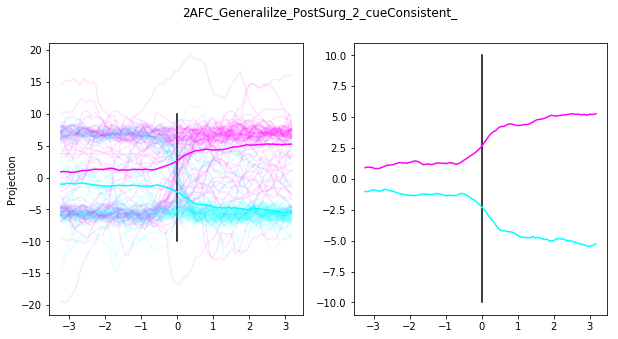

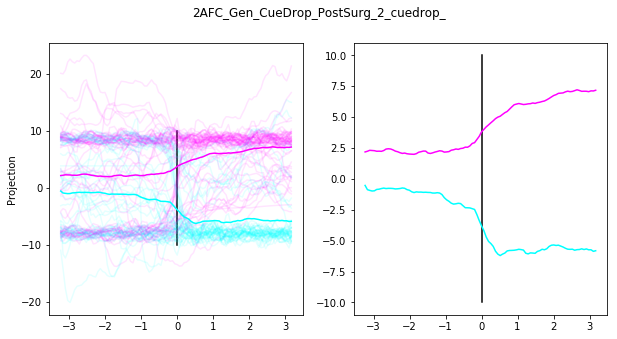

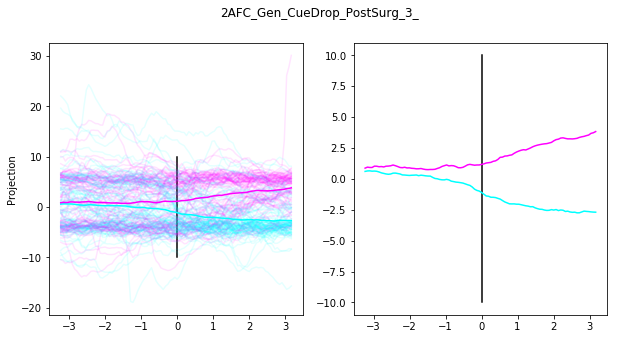

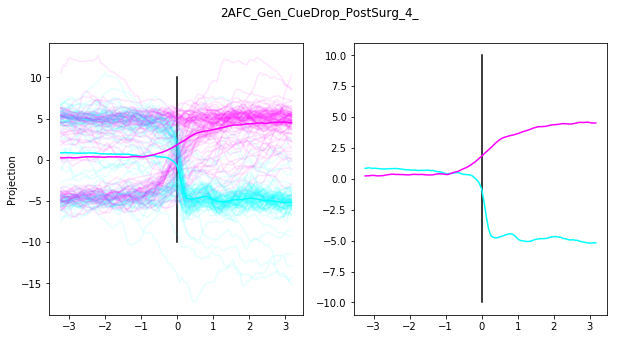

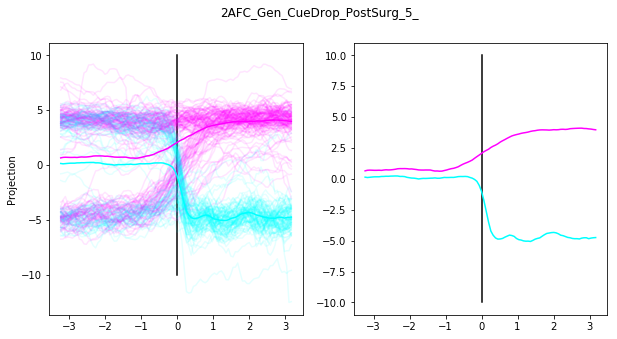

In [10]:
# single session projections
LDAs = []

for i in range(len(CaFiles)):
    f,ax = plt.subplots(1,2,figsize=[10,5])
    plt.suptitle(sessions[i],figure= f,size='large')

    ax[0].plot([0, 0], [-10, 10],c='black')
    ax[1].plot([0, 0], [-10, 10],c='black')
    
    
    
    
    print(sessions[i])
    ca_dat, behavior, tstart_inds, reward_inds = Ca_Dat[i], Behavior[i], TStartI[i], RewardI[i]
    C_dec = sp.stats.zscore(ca_dat['C_dec'][behavior['ca_inds'].values,:],axis=0)
    base_trial_mask = np.where(((behavior['morph'].values==1) | (behavior['morph'].values==0)) & 
                              ((behavior['rewards']==1) | (behavior['rewards']==-1) | 
                               (behavior['rewards']==2)|(behavior['rewards']==-2)))[0]
    lda = LDA(n_components=1)
    C_base_lda = lda.fit_transform(C_dec[base_trial_mask,:],behavior['morph'].values[base_trial_mask])
    C_lda = lda.transform(C_dec)
    

    LDAs.append(lda)
    
    trialMat_proj, morphVec = trial_tensor(C_lda,behavior['morph'].values,tstart_inds)
    
    morphAvg_proj, morphVals = across_trial_avg(trialMat_proj,morphVec)
    

    ax[0].set_ylabel("Projection")
    for ind,t in enumerate(tstart_inds.tolist()):
        ax[0].plot(np.arange(-50,50)/15.46,trialMat_proj[ind,:,:],c=plt.cm.cool(morphVec[ind]),alpha=.1)
        

        if (morphVec[ind]!=1.0) and (morphVec[ind]!=0.0):
            ax[1].plot(np.arange(-50,50)/15.46,trialMat_proj[ind,:,:],c=plt.cm.cool(behavior['morph'].values[t]),alpha=.2)
            

    print(morphAvg_proj.shape)
    for i,val in enumerate(morphVals.tolist()):
        ax[0].plot(np.arange(-50,50)/15.46,np.squeeze(morphAvg_proj[i,:]),c=plt.cm.cool(val))
        ax[1].plot(np.arange(-50,50)/15.46,np.squeeze(morphAvg_proj[i,:]),c=plt.cm.cool(val))

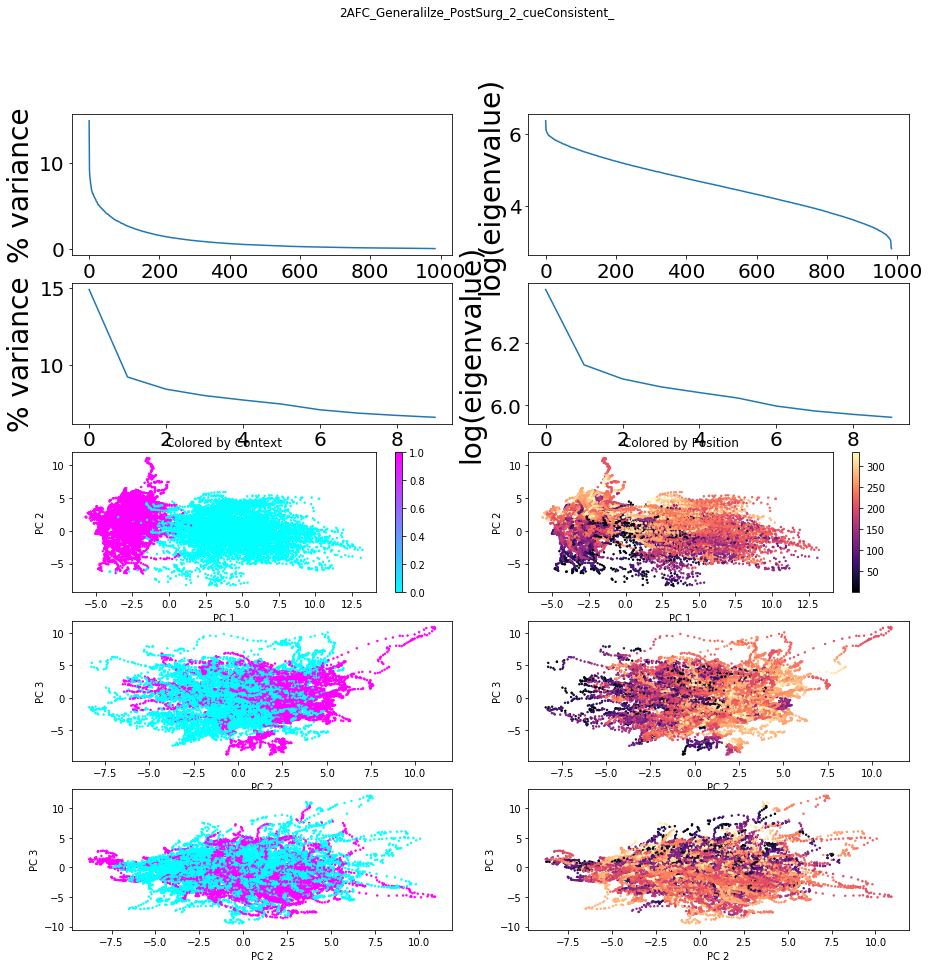

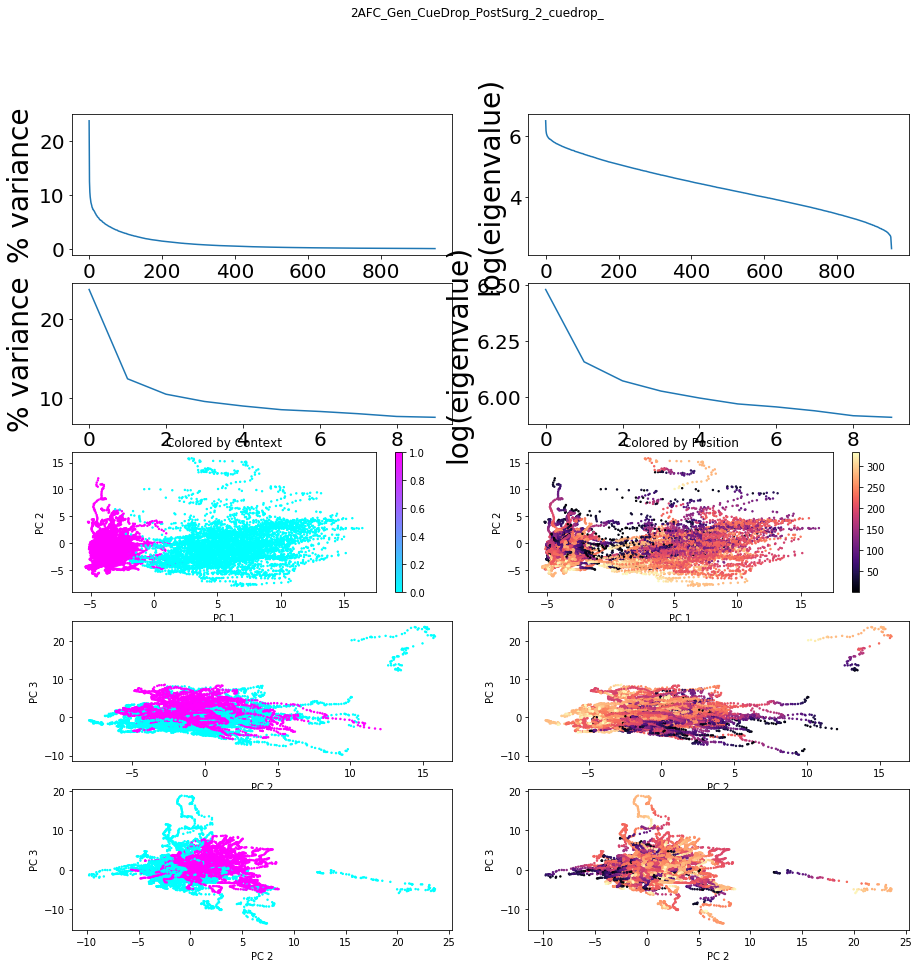

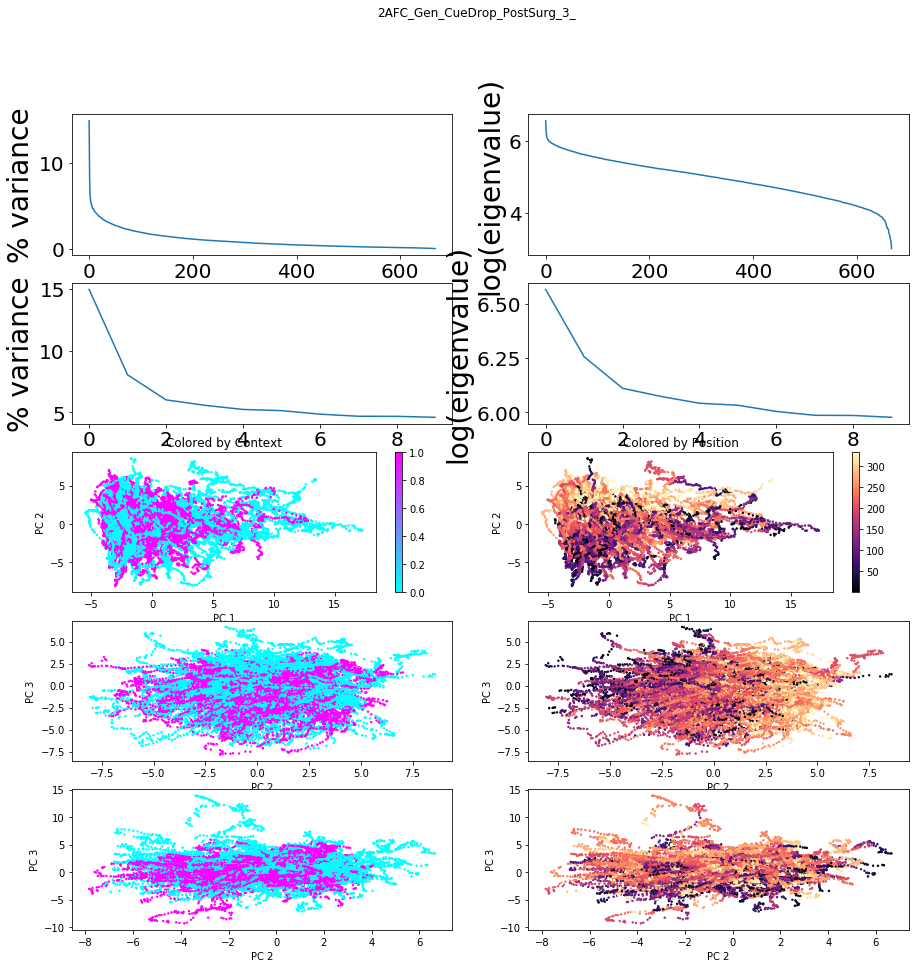

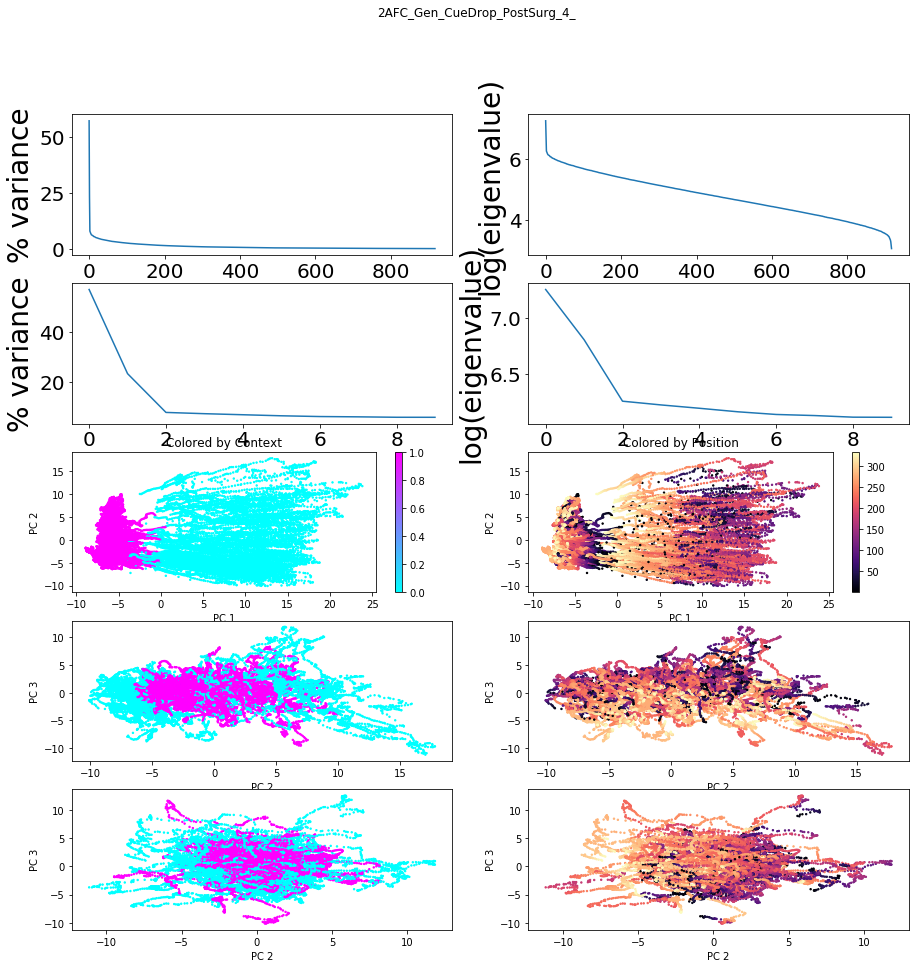

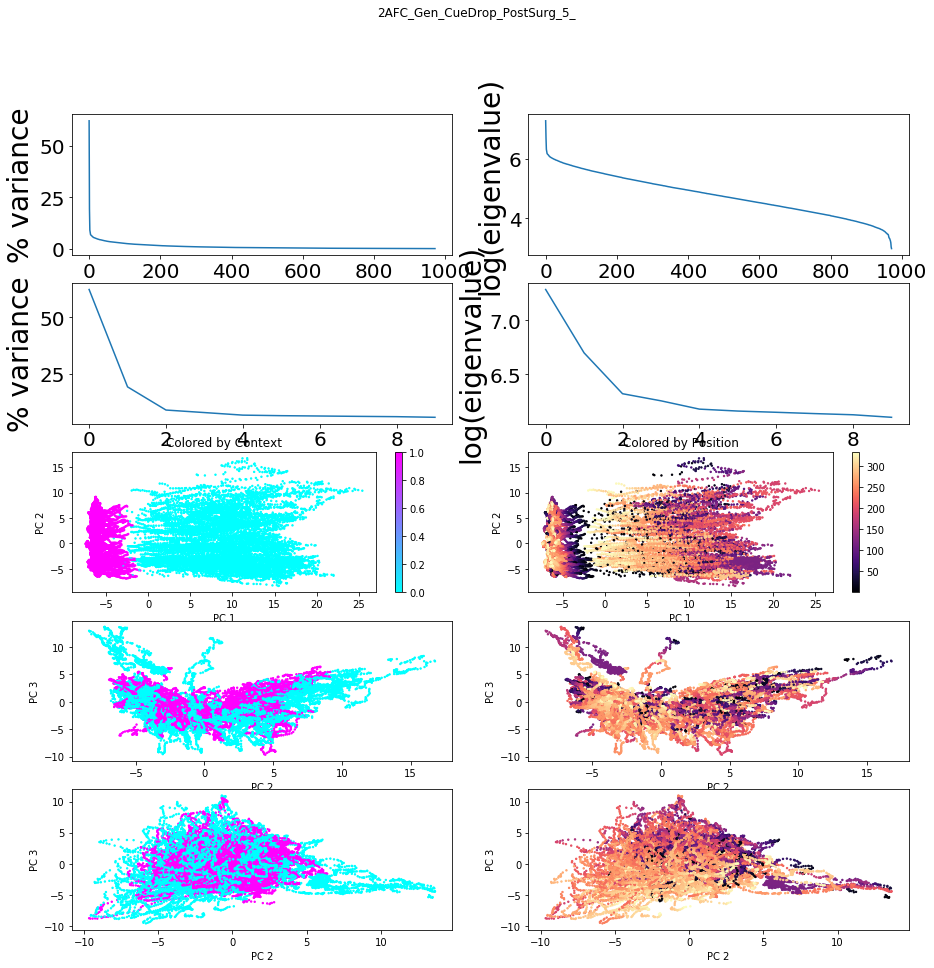

In [11]:
for i in range(len(CaFiles)):
    
    pca = PCA()
    C_dec = sp.stats.zscore(Ca_Dat[i]['C_dec'][Behavior[i]['ca_inds'].values,:],axis=0)
    C_pca = pca.fit_transform(C_dec)
    
    # skree plots
    f,axarr = plt.subplots(5,2,figsize=[15,15])
    plt.suptitle(sessions[i],figure= f,size='large')
    axarr[0,0].plot(pca.explained_variance_)
    axarr[0,0].set_ylabel("% variance",size=28)
    axarr[0,0].tick_params(labelsize=20)

    axarr[0,1].plot(np.log(pca.singular_values_))
    axarr[0,1].set_ylabel("log(eigenvalue)",size=28)
    axarr[0,1].tick_params(labelsize=20)

    axarr[1,0].plot(pca.explained_variance_[:10])
    axarr[1,0].set_ylabel("% variance",size=28)
    axarr[1,0].tick_params(labelsize=20)


    axarr[1,1].plot(np.log(pca.singular_values_[:10]))
    axarr[1,1].set_ylabel("log(eigenvalue)",size=28)
    axarr[1,1].tick_params(labelsize=20)

    
    trialMask = Behavior[i]['position'].values>0
    context_trialMask = (Behavior[i]['position'].values>0) & (Behavior[i]['morph'].values!=0) &(Behavior[i]['morph'].values!=1)



    s_cxt=axarr[2,0].scatter(C_pca[trialMask,0],C_pca[trialMask,1],c=Behavior[i]['morph'].values[trialMask],cmap='cool',s=2)
    plt.colorbar(s_cxt,ax=axarr[2,0])
    axarr[2,0].set_title('Colored by Context')
    axarr[2,0].set_xlabel("PC 1")
    axarr[2,0].set_ylabel("PC 2")

    s_pos=axarr[2,1].scatter(C_pca[trialMask,0],C_pca[trialMask,1],c=Behavior[i]['position'].values[trialMask],cmap='magma',s=2)
    plt.colorbar(s_pos,ax=axarr[2,1])
    axarr[2,1].set_title('Colored by Position')
    axarr[2,1].set_xlabel("PC 1")
    axarr[2,1].set_ylabel("PC 2")

    s_cxt=axarr[3,0].scatter(C_pca[trialMask,1],C_pca[trialMask,2],c=Behavior[i]['morph'].values[trialMask],cmap='cool',s=2)
    axarr[3,0].set_xlabel("PC 2")
    axarr[3,0].set_ylabel("PC 3")

    s_cxt=axarr[3,1].scatter(C_pca[trialMask,1],C_pca[trialMask,2],c=Behavior[i]['position'].values[trialMask],cmap='magma',s=2)
    axarr[3,1].set_xlabel("PC 2")
    axarr[3,1].set_ylabel("PC 3")
    
    s_cxt=axarr[4,0].scatter(C_pca[trialMask,2],C_pca[trialMask,3],c=Behavior[i]['morph'].values[trialMask],cmap='cool',s=2)
    axarr[4,0].set_xlabel("PC 2")
    axarr[4,0].set_ylabel("PC 3")

    s_cxt=axarr[4,1].scatter(C_pca[trialMask,2],C_pca[trialMask,3],c=Behavior[i]['position'].values[trialMask],cmap='magma',s=2)
    axarr[4,1].set_xlabel("PC 2")
    axarr[4,1].set_ylabel("PC 3")

(10673,)
(10673, 985) (10673,)


Z:\scripts\morph_experiments\utilities.py:33: RuntimeWarning: invalid value encountered in true_divide
  p_map = gaussian_filter(frmap[:,i],2)/frmap[:,i].sum()
Z:\scripts\morph_experiments\utilities.py:75: RuntimeWarning: invalid value encountered in greater
  p[cell] = np.where(SI[cell]>shuffled_SI[:,cell])[0].shape[0]/nperms
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


(12222,)
(12222, 985) (12222,)
(7857,)
(7857, 950) (7857,)
(10089,)
(10089, 950) (10089,)
(17254,)
(17254, 668) (17254,)
(16573,)
(16573, 668) (16573,)
(15960,)
(15960, 918) (15960,)
(18919,)
(18919, 918) (18919,)
(15508,)
(15508, 972) (15508,)
(18618,)
(18618, 972) (18618,)


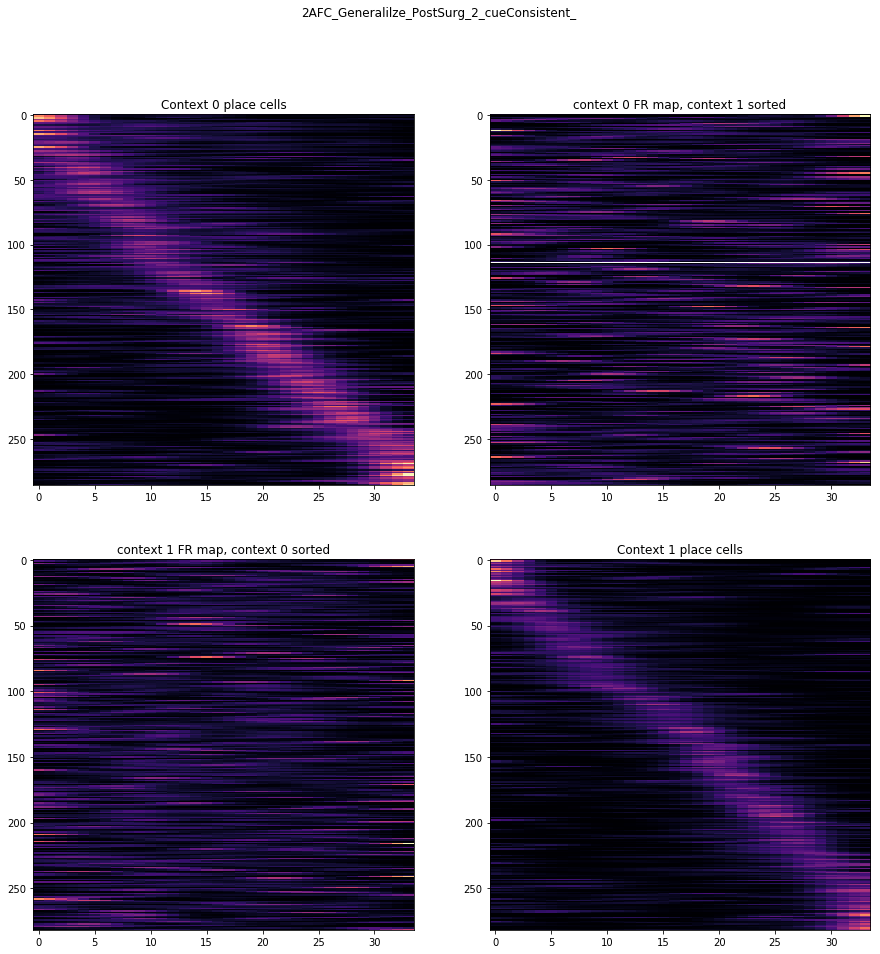

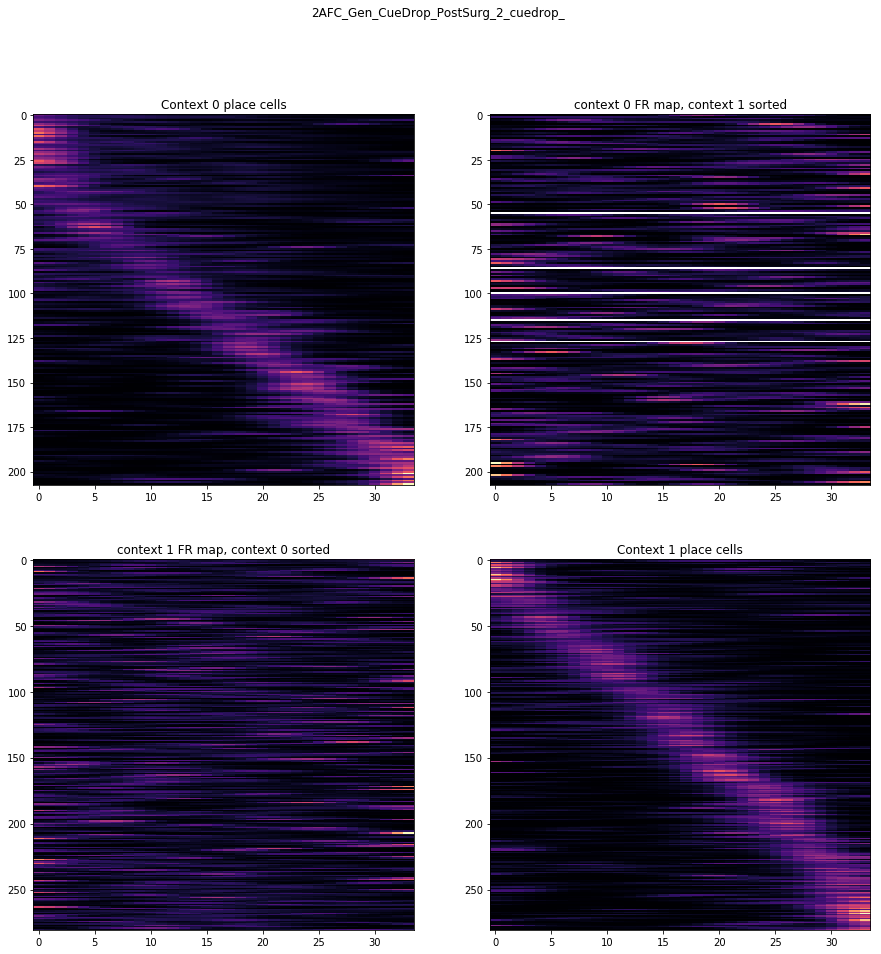

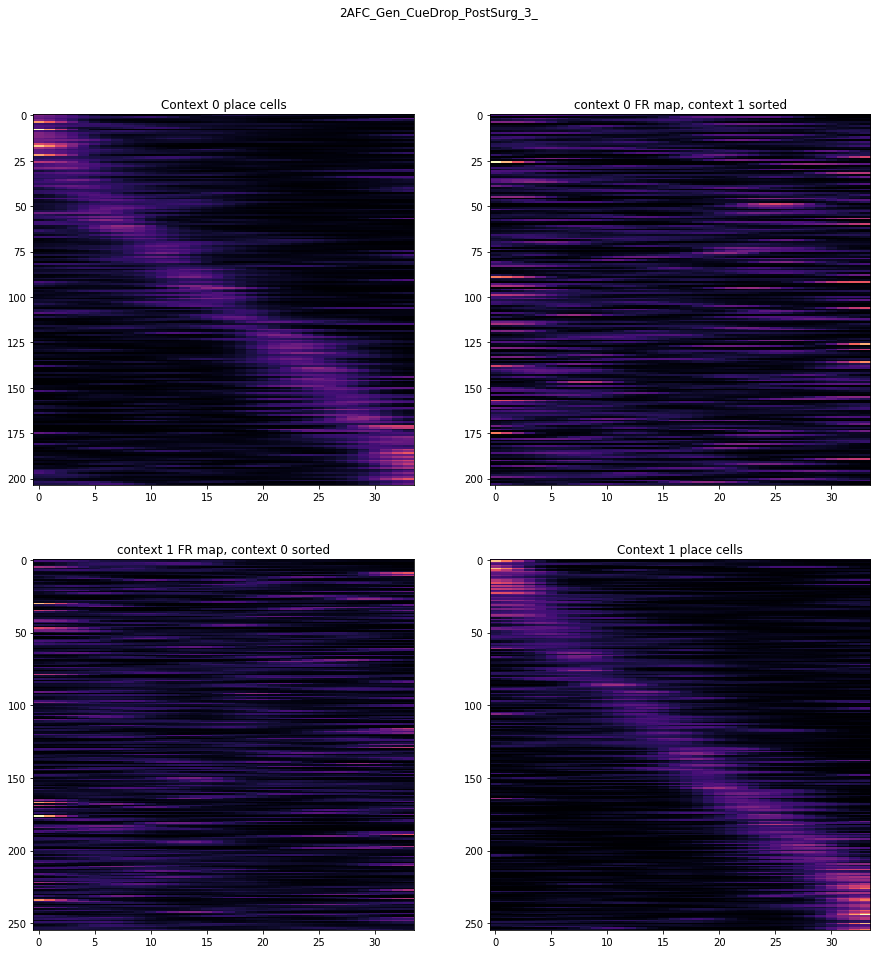

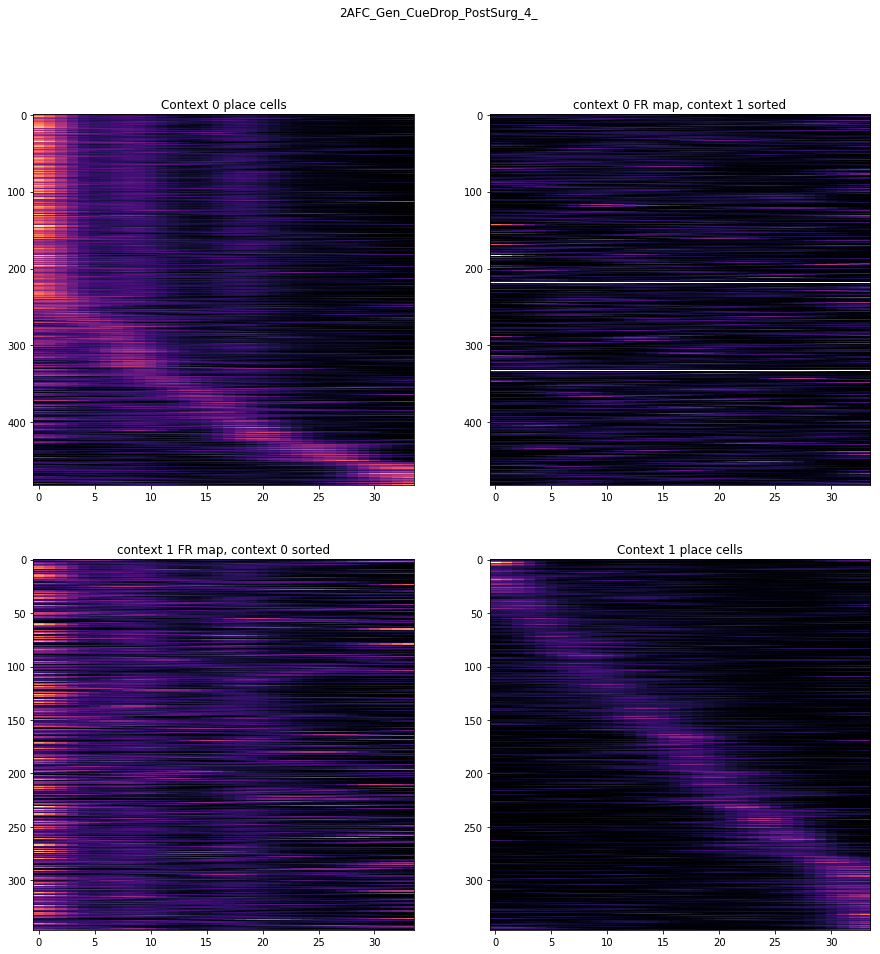

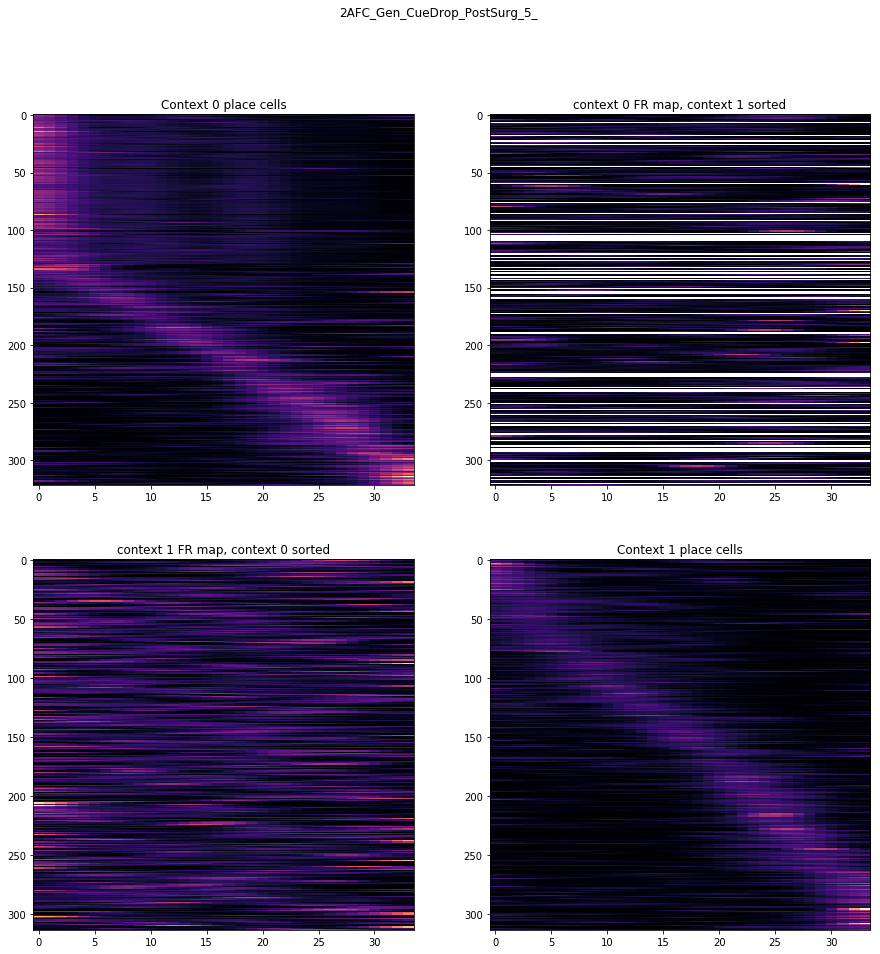

In [16]:
P,SI, FRmap = {},{},{}
for i in range(len(CaFiles)):
    behavior = Behavior[i]
    C = Ca_Dat[i]['S_dec'][Behavior[i]['ca_inds'].values,:]
    f,ax = plt.subplots(2,2,figsize=[15,15])
    plt.suptitle(sessions[i])
    P[i],SI[i], FRmap[i] = [],[],[]
    for val in [0, 1]:
        mask = behavior['morph'].values==val
        print(np.where(mask)[0].shape)
        print(C[mask,:].shape,behavior['position'].values[mask].shape)
        frmap, occupancy = utilities.rate_map(C[mask,:],behavior['position'].values[mask])
        si = utilities.spatial_info(frmap,occupancy)
        p = utilities.spatial_info_perm_test(si,C[mask,:],behavior['position'].values[mask],nperms = 100)
        
        P[i].append(p)
        SI[i].append(si)
        FRmap[i].append(frmap)
    
        frmap_sig = frmap[:,p>.95]
        maxInds = np.argmax(frmap_sig,axis=0)
        normMat = np.zeros(frmap_sig.shape)
        for j in range(frmap_sig.shape[1]):
            normMat[:,j] = gaussian_filter(frmap_sig[:,j],2)/frmap_sig[:,j].sum()
        sortVec = np.argsort(maxInds)
        ax[val,val].imshow(normMat[:,sortVec].T,aspect='auto',cmap='magma')
        ax[val,val].set_title("Context %i place cells" % val)
        
        mask_other = behavior['morph'].values == np.abs(val-1)
        frmap_other,occ_other = utilities.rate_map(C[mask_other,:],behavior['position'].values[mask_other])
        frmap_other_sig = frmap_other[:,p>.95]
        
        
        normMat_other = np.zeros(frmap_other_sig.shape)
        for j in range(frmap_other_sig.shape[1]):
            normMat_other[:,j] = gaussian_filter(frmap_other_sig[:,j],2)/frmap_other_sig[:,j].sum()
            
        normMat_other_sort = normMat_other[:,sortVec]
        ax[val,int(np.abs(val-1))].imshow(normMat_other_sort[:,sortVec].T,aspect='auto',cmap='magma')
        ax[val,int(np.abs(val-1))].set_title("context %i FR map, context %i sorted" % (val, int(np.abs(val-1))))
        
        # add plot below rate maps showing where density of new place fields are
        
        

mean accuracy 0.499454
mean accuracy 0.536640
mean accuracy 0.263267
mean accuracy 0.294624
mean accuracy 0.340659


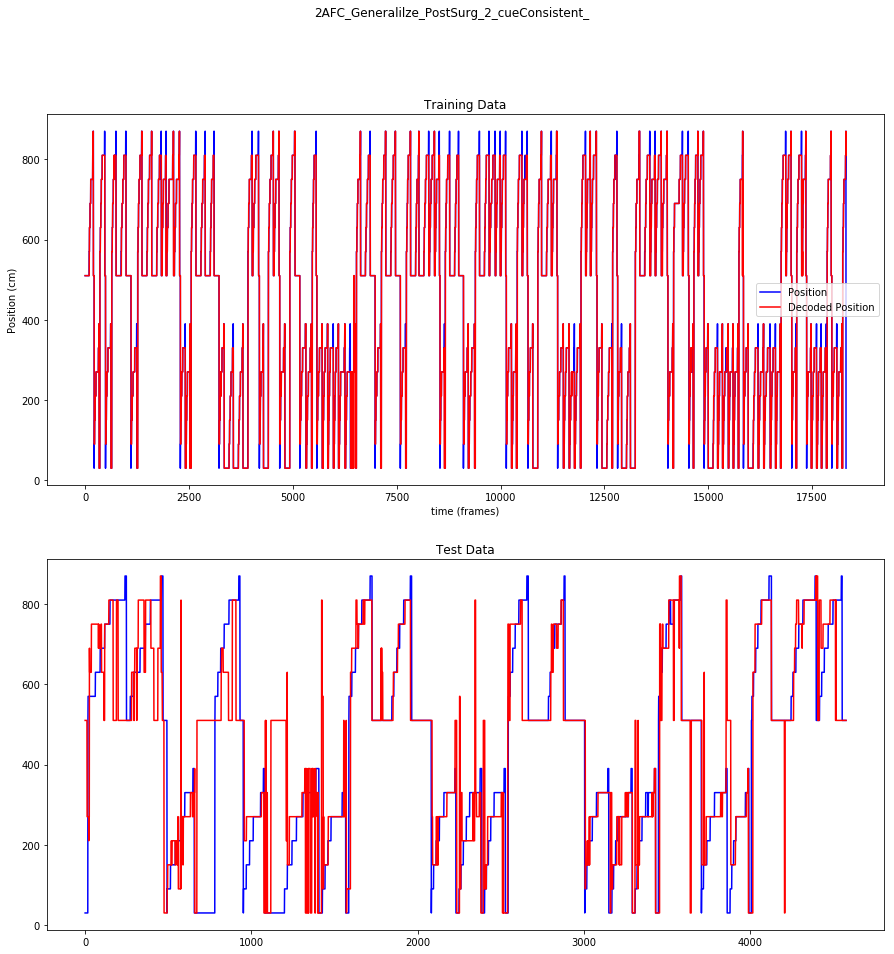

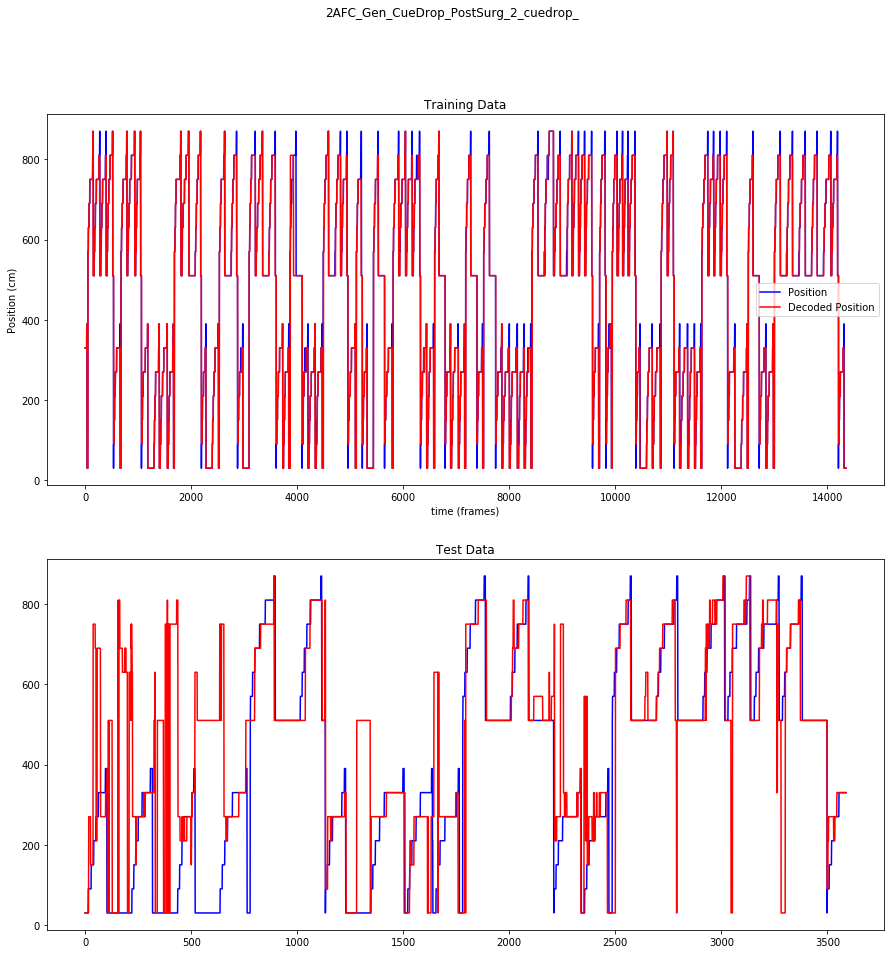

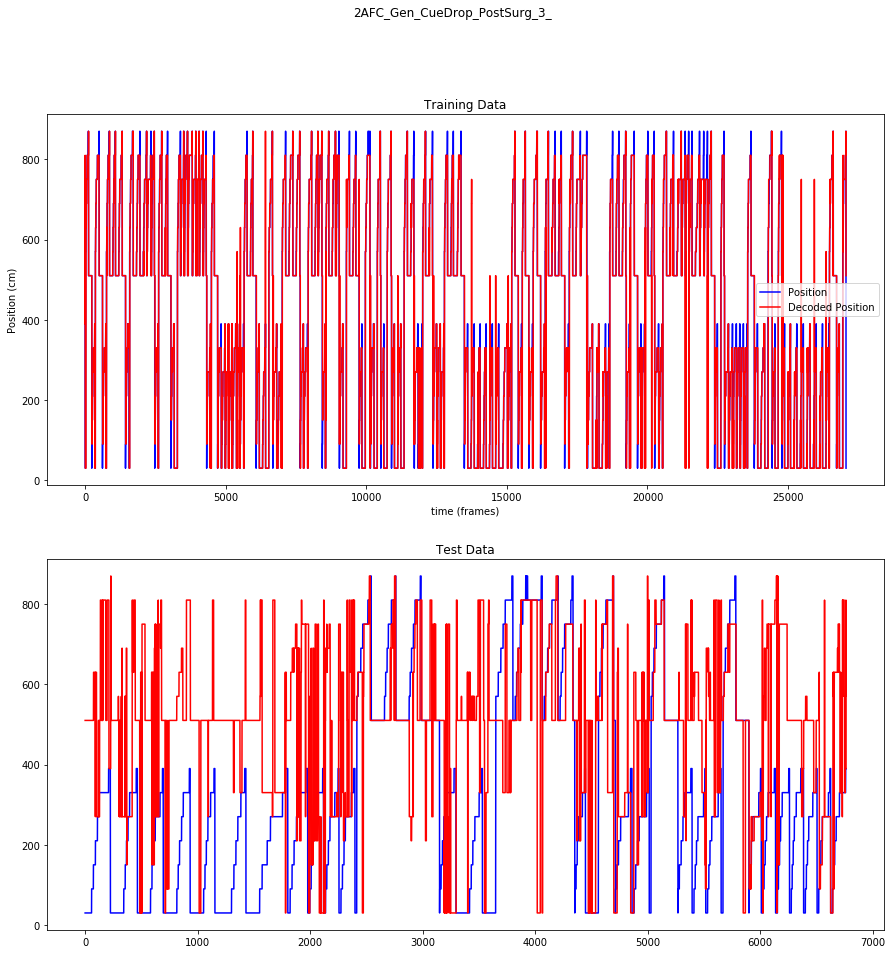

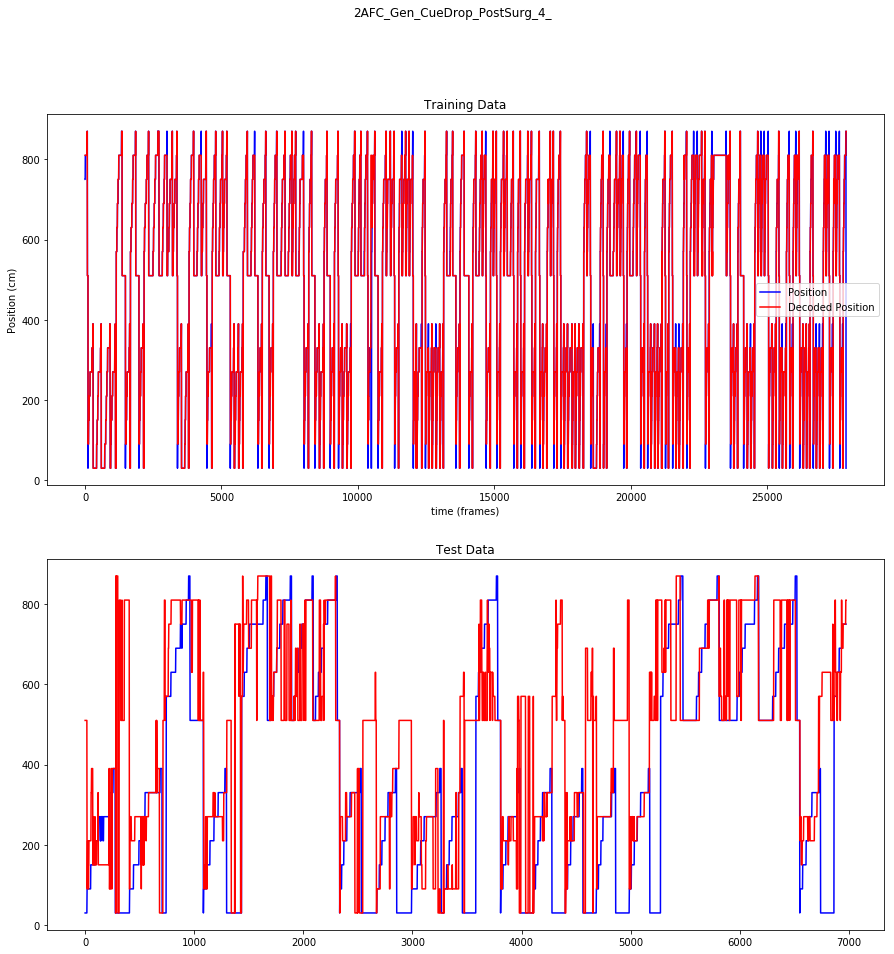

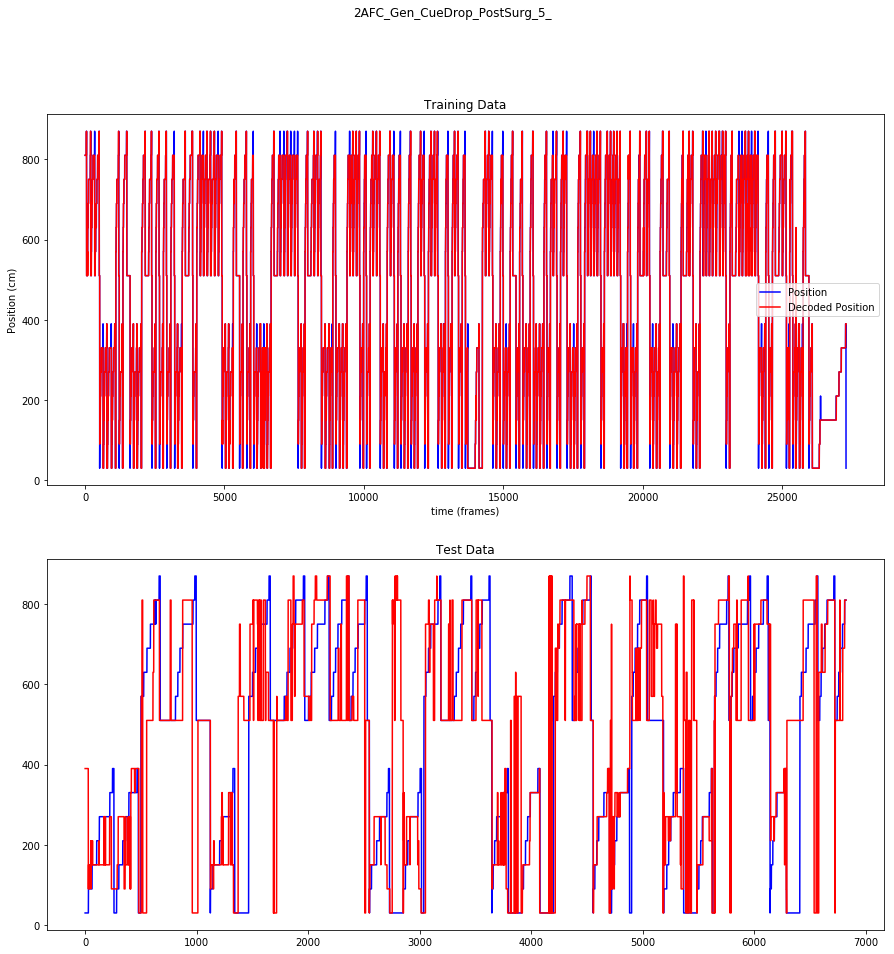

In [18]:
from sklearn.linear_model import LogisticRegression
# bin position into 10 cm bins
for i in range(len(CaFiles)):
    
    
    C_dec = sp.stats.zscore(Ca_Dat[i]['C_dec'][Behavior[i]['ca_inds'].values,:],axis=0)
    pos = Behavior[i]['position'].values
    context = Behavior[i]['morph'].values
    
    pos_binned = np.zeros(pos.shape)

    bin_edges = np.arange(-60,375,60).tolist()
    bin_centers = [(bin_edges[k]+bin_edges[k+1])/2 for k in range(len(bin_edges)-1)]
    for j,(edge1,edge2) in enumerate(zip(bin_edges[:-1],bin_edges[1:])):
        pos_binned[(pos>edge1) & (pos<=edge2)] = j+1

    labels = pos_binned+ context*len(bin_edges)
    mid_point = int(C_dec.shape[0]*.2)
    LR = LogisticRegression(penalty = 'l2', solver = 'newton-cg',multi_class='multinomial',C=.001)
    LR.fit(C_dec[mid_point:,:],labels[mid_point:])


    f,ax = plt.subplots(2,1,figsize=[15,15])
    plt.suptitle(sessions[i],figure= f,size='large')
    
    ax[0].plot(60.*labels[mid_point:]-30,color='blue')
    ax[0].plot(60.*LR.predict(C_dec[mid_point:,:])-30,color='red')
    ax[0].set_title('Training Data')
    ax[0].set_ylabel('Position (cm)')
    ax[0].set_xlabel('time (frames)')
    ax[0].legend(['Position','Decoded Position'])
    pos_predict = 60.*LR.predict(C_dec[:mid_point,:])-30
    ax[1].plot(60.*labels[:mid_point]-30,color='blue')
    ax[1].plot(pos_predict,color='red')
    ax[1].set_title('Test Data')
    print('mean accuracy %f' % LR.score(C_dec[:mid_point,:], labels[:mid_point]))